In [0]:
from pandas_datareader import data as wb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time


In [0]:
def download_action(acao,start):
  '''acao: sigla com VVAR3,
    start: data de inicio no formato ano-mes-dia'''
  ac = acao +'.SA'
  serie = wb.DataReader(ac,data_source='yahoo',start=start)
  return serie

In [0]:
mglu = download_action('MGLU3','2017-1-1 ')

In [97]:
mglu.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-12-09,46.500000,45.320000,45.400002,45.849998,12761500.0,45.849998
2019-12-10,46.599998,45.299999,45.939999,46.599998,8437900.0,46.599998
2019-12-11,47.900002,46.650002,46.880001,47.580002,11267900.0,47.580002
2019-12-12,48.369999,47.529999,47.959999,47.830002,9065400.0,47.830002
2019-12-13,49.660000,48.000000,48.299999,49.599998,10076300.0,49.599998


In [0]:
import plotly.graph_objects as go 
import pandas as pd
from datetime import datetime

In [0]:
def Candlestick_plot(act):  
  fig = go.Figure(data=[go.Candlestick(x=act.index,
                        open = act['Open'],
                        high = act['High'],
                        low = act['Low'],
                        close = act['Close'])])
  fig.show()

In [7]:
Candlestick_plot(mglu)

# Processamento inicial

In [0]:
# padronizando dados
from sklearn.preprocessing import MinMaxScaler

In [0]:
# normaliza os dados
def scala_norm(array):
  """
  Normaliza a array em valores entre 0 e 1 \n
  array: array ou lista com os valores a serem normalizados
  """
  normalizador = MinMaxScaler(feature_range=(0,1))
  base = normalizador.fit_transform(array.reshape(-1, 1))
  return base , normalizador
  

In [0]:
# define define x e y
def def_conjXY(df,intervalo,item = 0):
  """
  :df = Dataframe com os dados; 
  :intervalo = quantidade de dias necessarios para previsao
  :indice referente a coluna a ser usada : 0 - High, 1 - Low, 2 - Open, 3 - Close
  :retorna conjunto X e Y
  """
  input_value = []
  output_value = []
  if type(df) == pd.core.frame.DataFrame:
    for i in range(intervalo,(len(df))):
      x = np.array(df.iloc[i-intervalo: i, item])
      y = np.array(df.iloc[i, item])    
      input_value.append(x)
      output_value.append(y)
  else:
    for i in range(intervalo,(len(df))):
      x = np.array(df[i-intervalo: i, item])
      y = np.array(df[i, item])    
      input_value.append(x)
      output_value.append(y)
  x_train = np.array(input_value)
  y_train = np.array(output_value)
  x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))

  return x_train , y_train



In [0]:
test = mglu.loc['2019-01-01':]

In [0]:
mglu = mglu.loc[:'2019-01-01']

In [0]:
# processando 
# 
preco_real_open = mglu.Open.values
preco_real_open , norma_open = scala_norm(preco_real_open)

preco_real_close = mglu.Close.values
preco_real_close , norma_close = scala_norm(preco_real_close)

preco_real_high = mglu.High.values
preco_real_high , norma_high = scala_norm(preco_real_high)

preco_real_low = mglu.Low.values
preco_real_low, norma_low = scala_norm(preco_real_low)

In [0]:
# estabelecendo X e Y
x_open , y_open = def_conjXY(preco_real_open,90)
x_close , y_close = def_conjXY(preco_real_close,90)
x_high , y_high = def_conjXY(preco_real_high,90)
x_low , y_low = def_conjXY(preco_real_low,90)


In [0]:
# estabelecendo previsores 

# 4 prevendo 4

X = np.column_stack((x_open,x_close,x_high,x_low))
Y = y_open
#Y = np.column_stack((y_open,y_close,y_high,y_low))


# Treinando o algoritmo

In [17]:
from keras.models import Sequential
from keras.layers import Dense , Dropout, LSTM
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

Using TensorFlow backend.


In [0]:
# criando regressor
regressor = Sequential()
regressor.add(LSTM(units= 100, return_sequences =True,
                  input_shape = (X.shape[1],1)))
regressor.add(Dropout(0.3)) # zera 30 % reduzindo o overphiting

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 50)) # se return_sequences = True pode dar erro por se ultima camda
regressor.add(Dropout(0.3))


regressor.add(Dense(units = 1, activation = 'sigmoid')) # pode ser sigmoid # considerando 1 saida

In [0]:
# compilando
regressor.compile(optimizer= 'rmsprop', loss = 'mean_squared_error',
                 metrics = ['mean_absolute_error'])




In [0]:
es = EarlyStopping(monitor = 'loss', min_delta= 1e-10, 
                   patience= 10, verbose = 1)

rlr = ReduceLROnPlateau(monitor = 'less', factor = 0.2, 
                     patience = 5, verbose = 1)

mcp = ModelCheckpoint(filepath='pesos.h5', monitor='loss',
                     save_best_only= True, verbose=1)

In [63]:
#treinando (rodar no terminal)
t1 = time.time()
regressor.fit(X, Y, epochs=100, batch_size= 32,
             callbacks=[es, rlr, mcp])

t2 = time.time()

print('!!!!!!!!!!!!!!!!!!!!!!!    Finalizado  !!!!!!!!!')
print(t2-t1)

Epoch 1/100
409/409 [==============================] - 21s 52ms/step - loss: 0.0342 - mean_absolute_error: 0.1495


/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1379: RuntimeWarning:

Reduce LR on plateau conditioned on metric `less` which is not available. Available metrics are: loss,mean_absolute_error,lr




Epoch 00001: loss improved from inf to 0.03419, saving model to pesos.h5
Epoch 2/100
409/409 [==============================] - 18s 45ms/step - loss: 0.0098 - mean_absolute_error: 0.0774

Epoch 00002: loss improved from 0.03419 to 0.00983, saving model to pesos.h5
Epoch 3/100
409/409 [==============================] - 18s 44ms/step - loss: 0.0069 - mean_absolute_error: 0.0682

Epoch 00003: loss improved from 0.00983 to 0.00693, saving model to pesos.h5
Epoch 4/100
409/409 [==============================] - 18s 43ms/step - loss: 0.0081 - mean_absolute_error: 0.0704

Epoch 00004: loss did not improve from 0.00693
Epoch 5/100
409/409 [==============================] - 18s 44ms/step - loss: 0.0077 - mean_absolute_error: 0.0683

Epoch 00005: loss did not improve from 0.00693
Epoch 6/100
409/409 [==============================] - 18s 43ms/step - loss: 0.0072 - mean_absolute_error: 0.0652

Epoch 00006: loss did not improve from 0.00693
Epoch 7/100
409/409 [==============================] - 1

In [64]:
1064/60

17.733333333333334

# Test

In [103]:
test.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-01-02,23.248800,22.3787,22.5525,23.248800,6754400.0,22.783854
2019-01-03,23.186300,22.4200,23.1238,23.000000,6585600.0,22.540028
2019-01-04,23.043800,22.2938,23.0063,22.299999,6930400.0,21.854027
2019-01-07,22.809999,22.1588,22.2500,22.646200,5293600.0,22.193306
2019-01-08,22.811300,22.3750,22.6938,22.463800,4849600.0,22.014553


In [0]:
# Variaveis teste 
#  
preco_real_open = test.Open.values
preco_real_open , norma_open = scala_norm(preco_real_open)

preco_real_close = test.Close.values
preco_real_close , norma_close = scala_norm(preco_real_close)

preco_real_high = test.High.values
preco_real_high , norma_high = scala_norm(preco_real_high)

preco_real_low = test.Low.values
preco_real_low, norma_low = scala_norm(preco_real_low)

x_open , y_open = def_conjXY(preco_real_open,90)
x_close , y_close = def_conjXY(preco_real_close,90)
x_high , y_high = def_conjXY(preco_real_high,90)
x_low , y_low = def_conjXY(preco_real_low,90)

# estabelecendo previsores 

# 4 prevendo 4

X_test = np.column_stack((x_open,x_close,x_high,x_low))
Y_test = y_open


In [0]:
Y_predict = regressor.predict(X_test)

In [0]:
Y_predict=norma_open.inverse_transform(Y_predict)
Y_test = norma_open.inverse_transform(Y_test.reshape(-1,1))

In [0]:
#

In [0]:
#Y_test = pd.DataFrame(Y_test,columns=['Open','Close','High','Low'])
#Y_predict = pd.DataFrame(Y_predict,columns=['Open','Close','High','Low'])

In [0]:
resultado = pd.DataFrame({'Previsto':Y_predict.flatten(),
                          'Real':Y_test.flatten()},
                         index = test.iloc[90:].index 
                         )

In [0]:
from sklearn.metrics import r2_score

In [109]:
r2_score(resultado.Real,resultado.Previsto)

0.8937760515509048

In [41]:
r2_score(Y_test.Close,Y_predict.Close)

0.9250099030113584

In [40]:
r2_score(Y_test.Low,Y_predict.Low)

0.9378317003290313

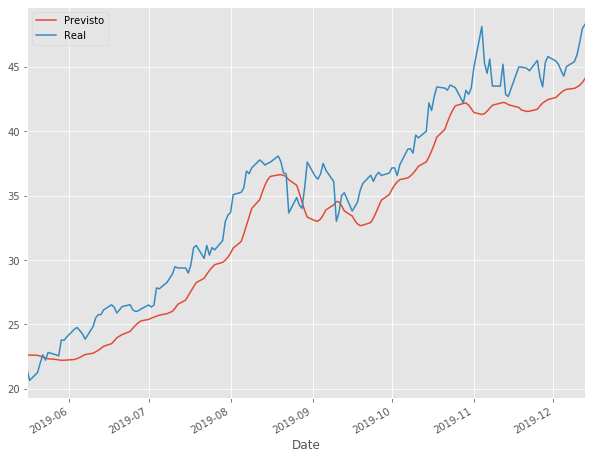

In [113]:

plt.style.use('ggplot')
resultado.plot(figsize=(10,8))
plt.savefig('prev_acoes.png')

In [114]:
resultado.describe()

,Previsto,Real
count,148.000000,148.000000
mean,33.165565,35.176166
std,7.103292,7.564538
min,22.202105,20.633801
25%,25.961478,28.744950
50%,33.859684,36.389999
75%,40.283562,42.740001
max,44.085854,48.299999
